# Adversarial attack: Fast Gradient Signed Method
> How to perform an Adversarial attack using Fast Gradient Signed Method in Tensorflow


- toc: true
- badges: true
- comments: true
- author: dzlab
- categories: [tensorflow, generative, adversarial]

Deep Learning have achieved remarquable results in many areas especially vision where today complex models trained on very large datasets are able to overperform domain experts. Yet those same models can be very vulnerable to attacks that slightly change the input data to fool the model. Those attacks are know as [Adversial Attacks](https://en.wikipedia.org/wiki/Adversarial_machine_learning) and can be performed in a variety of ways (see [link1](https://venturebeat.com/2021/05/29/adversarial-attacks-in-machine-learning-what-they-are-and-how-to-stop-them/), [link2](https://viso.ai/deep-learning/adversarial-machine-learning/)).

Those attacks can be serious with devastating results (e.g. fooling a self-driving), so known how to check that your model is robust against them is crutial before rolling the model to production.

![adversial attack on self-driving car](https://viso.ai/wp-content/uploads/2021/06/adversarial-attack-example-detection.jpg "source: https://viso.ai/deep-learning/adversarial-machine-learning/")

In this article, we will see how to implement one simple and effective Adversial Attack called [Fast Gradient Signed Method (FGSM)](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm). 

FGSM is implemented by performing the following steps:
- Pass an legitimage image over a model and capture the gradients
- Determining the direction (sign) of the gradient at each pixel of the original image
- Using that information create an adversarial pattern in a way to aximize the loss at each pixel
- Multiply this pattern by a small scaling value and apply it (i.e. add or substruct) to the original image
- The result is an Adversial image that looks to the human eye very similar to the original image


Although this attack performs small imperceptible perturbations into an image, we will see in action how this technique can easily fool a pre-trained model.

Before starting, make sure to have OpenCV installed as it will be used for performing the perturbations


In [44]:
#collapse
!pip install opencv-contrib-python

Import the dependencies

In [45]:
#collapse
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.nasnet import *
from tensorflow.keras.losses import CategoricalCrossentropy

Load the pre-trained model (in this case `NASNetMobile`) and freeze its weights so they are not updated after a forward pass.

In [46]:
pretrained_model = NASNetMobile(include_top=True, weights='imagenet')
pretrained_model.trainable = False

We need to define a function to preprocess an image with same preprocessing steps performed on the images used to train the target model (e.g. resizing)

In [47]:
def preprocess(image, target_shape):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    image = preprocess_input(image)
    image = image[None, :, :, :]
    return image

We also need to define a function that turns the model output probabilities into actual labels

In [48]:
def get_imagenet_label(probabilities):
    return decode_predictions(probabilities, top=1)[0][0]

Define a function to create the adversarial pattern that will be used later to generate the adversial image

In [49]:
def generate_adv_pattern(model, input_image, input_label, loss_function):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_function(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_gradient = tf.sign(gradient)
    return signed_gradient

The pattern is nothing but a tensor with the sign of the gradient in each element. i.e., `signed_gradient` is:
- -1 for negative gradients (i.e. value below 0)
- 1 for positive gradients (i.e. value above 0)
- 0 if the gradient is 0.

We need a legitimate image so we can apply perturbations on it, you can download a test image on your own or use this Pug image

In [50]:
!curl https://image.freepik.com/free-vector/angry-dog-pug-prisoner-graphic-illustration_41984-29.jpg -o dog.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  102k  100  102k    0     0   776k      0 --:--:-- --:--:-- --:--:--  776k


Pass the image through the pretrained model to get output probabilities

In [51]:
image = tf.io.read_file('dog.jpg')
image = tf.image.decode_jpeg(image)
image = preprocess(image, pretrained_model.input.shape[1:-1])
image_probs = pretrained_model.predict(image)

We need to One-hot encode the ground truth label of the original image, then use it to generate an adversarial pattern

In [52]:
cce_loss = CategoricalCrossentropy()
pug_index = 254
label = tf.one_hot(pug_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
disturbances = generate_adv_pattern(pretrained_model, image, label, cce_loss)

> Note: if you want try this techniques on a different image of a different class than `pug` then look up the corresponding class index in this imagenet class indices - [link](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

Next, we define a utility function to generate an adversial version of an image based on a disturbance/noise and a scalar



In [53]:
def generate_adv_image(image, epsilon, disturbances):
    corrupted_image = image + epsilon * disturbances
    return tf.clip_by_value(corrupted_image, -1, 1)

We also, need another utility function to ensure before plotting that the input tensor in the [0, 255] range, as well as in BGR space, which is the one used by OpenCV

In [54]:
def postprocess_adv_image(adv_image):
    adv_image = adv_image.numpy()[0] * 0.5 + 0.5
    adv_image = (adv_image * 255).astype('uint8')
    return cv2.cvtColor(adv_image, cv2.COLOR_RGB2BGR)

We can use the previous utility function to show what the noise looks like before applying it to the original image

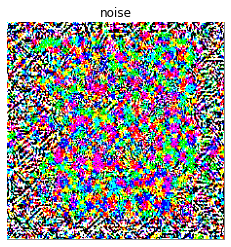

In [55]:
disturbed_image = postprocess_adv_image(disturbances)
plt.imshow(disturbed_image)
plt.axis('off')
plt.title("noise");

Finally, we can put all the previous steps together to perform a series of adversarial attacks different values of epsilon (which is used as noise multiplier).

After that we disply the corresponding adversial example as well the predicted label and confidence provided by the victim model

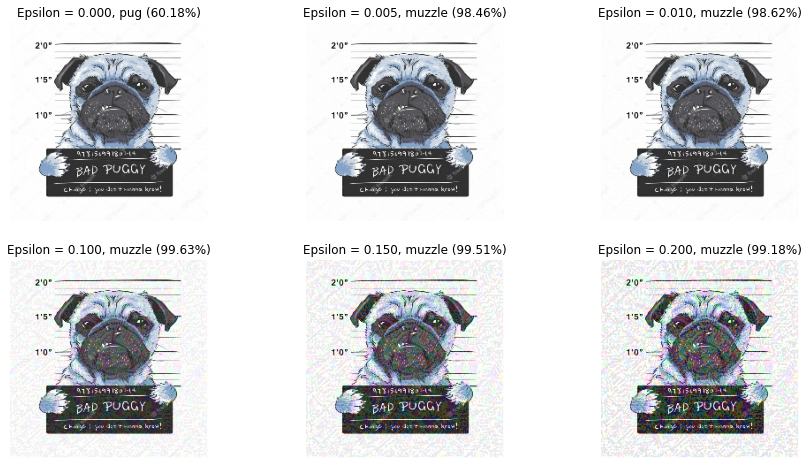

In [56]:
figure, axis = plt.subplots(2, 3, figsize=(15, 8))
for index, epsilon in enumerate([0, 0.005, 0.01, 0.1, 0.15, 0.2]):
    adv_image = generate_adv_image(image, epsilon, disturbances)
    prediction = pretrained_model.predict(adv_image)
    _, label, confidence = get_imagenet_label(prediction)
    adv_image = postprocess_adv_image(adv_image)
    confidencePct = confidence * 100
    title = f'Epsilon = {epsilon:.3f}, {label} ({confidencePct:.2f}%)'
    row, col = int(index / 3), index % 3
    axis[row, col].imshow(adv_image)
    axis[row, col].set_title(title)
    axis[row, col].axis('off')


As you can be see from the output images and the resulting classification, an imperceptible variation in the pixel values produced a drastically different response from the network.

- For epsilon = 0 (no attack), the label is Pug with a 60.18% confidence
- When epsilon = 0.005 (a very small perturbation), the label changes to Muzzle, with a 98.46% confidence!
- The situation gets worse as we increase the magnitude of epsilon.
